Small Dataset (316)
Mode-catboost
Features- 35 RDKit Descriptors + Morgan Finger prints
Targets- Homo,Lumo,Gap
5-Fold Cross Validation

In [11]:
pip install catboost

  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 16.5 MB/s eta 0:00:00a 0:00:01
Using cached graphviz-0.21-py3-none-any.whl (47 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [catboost]1/2 [catboost]
Note: you may need to restart the kernel to use updated packages.


In [13]:
"""
MULTI-TARGET MODEL FOR HOMO, LUMO, AND GAP PREDICTION
===================================================
Features: 35 RDKit descriptors + 2048 Morgan fingerprints
Model: CatBoost with Optuna-optimized hyperparameters
"""

import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors, rdFingerprintGenerator
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("MULTI-TARGET MODEL - HOMO, LUMO, AND GAP PREDICTION")
print("="*70)

# ============================================================================
# FEATURE EXTRACTION (Same as before)
# ============================================================================

def get_rdkit_descriptors(smiles):
    """Extract 35 RDKit molecular descriptors"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    features = {
        'num_aromatic_rings': Descriptors.NumAromaticRings(mol),
        'num_aromatic_bonds': sum([1 for b in mol.GetBonds() if b.GetIsAromatic()]),
        'num_aromatic_carbocycles': Descriptors.NumAromaticCarbocycles(mol),
        'num_aromatic_heterocycles': Descriptors.NumAromaticHeterocycles(mol),
        'num_heteroatoms': Descriptors.NumHeteroatoms(mol),
        'num_saturated_rings': Descriptors.NumSaturatedRings(mol),
        'fraction_sp2': sum([1 for a in mol.GetAtoms() 
                            if a.GetHybridization() == Chem.HybridizationType.SP2]) / max(mol.GetNumAtoms(), 1),
        'fraction_sp3': sum([1 for a in mol.GetAtoms() 
                            if a.GetHybridization() == Chem.HybridizationType.SP3]) / max(mol.GetNumAtoms(), 1),
        'fraction_aromatic': sum([1 for a in mol.GetAtoms() 
                                 if a.GetIsAromatic()]) / max(mol.GetNumAtoms(), 1),
        'molecular_weight': Descriptors.MolWt(mol),
        'num_atoms': mol.GetNumAtoms(),
        'num_heavy_atoms': mol.GetNumHeavyAtoms(),
        'num_rings': rdMolDescriptors.CalcNumRings(mol),
        'num_rotatable_bonds': Lipinski.NumRotatableBonds(mol),
        'num_hbd': Lipinski.NumHDonors(mol),
        'num_hba': Lipinski.NumHAcceptors(mol),
        'tpsa': Descriptors.TPSA(mol),
        'bertz_complexity': Descriptors.BertzCT(mol),
        'kappa1': Descriptors.Kappa1(mol),
        'kappa2': Descriptors.Kappa2(mol),
        'kappa3': Descriptors.Kappa3(mol),
        'max_estate': Descriptors.MaxEStateIndex(mol),
        'min_estate': Descriptors.MinEStateIndex(mol),
        'mol_logp': Descriptors.MolLogP(mol),
        'mol_mr': Descriptors.MolMR(mol),
        'chi0v': Descriptors.Chi0v(mol),
        'chi1v': Descriptors.Chi1v(mol),
        'chi2v': Descriptors.Chi2v(mol),
        'chi3v': Descriptors.Chi3v(mol),
        'chi4v': Descriptors.Chi4v(mol),
        'total_valence': sum([a.GetTotalValence() for a in mol.GetAtoms()]),
        'formal_charge': Chem.GetFormalCharge(mol),
        'num_carbon': sum([1 for a in mol.GetAtoms() if a.GetSymbol() == 'C']),
        'num_nitrogen': sum([1 for a in mol.GetAtoms() if a.GetSymbol() == 'N']),
        'num_oxygen': sum([1 for a in mol.GetAtoms() if a.GetSymbol() == 'O']),
        'num_sulfur': sum([1 for a in mol.GetAtoms() if a.GetSymbol() == 'S']),
    }
    
    return list(features.values())

def get_morgan_fingerprint(smiles, radius=2, n_bits=2048):
    """Generate 2048-bit Morgan fingerprints"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    generator = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=n_bits)
    fp = generator.GetFingerprint(mol)
    
    arr = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    
    return arr.tolist()

def get_combined_features(smiles):
    """Combine RDKit + Morgan features"""
    rdkit_features = get_rdkit_descriptors(smiles)
    if rdkit_features is None:
        return None
    
    morgan_fp = get_morgan_fingerprint(smiles, radius=2, n_bits=2048)
    if morgan_fp is None:
        return None
    
    return rdkit_features + morgan_fp

# ============================================================================
# OPTIMIZED PARAMETERS
# ============================================================================

BEST_PARAMS = {
    'iterations': 1500,
    'depth': 4,
    'learning_rate': 0.0299,
    'l2_leaf_reg': 1.021,
    'bagging_temperature': 0.47,
    'random_strength': 5.73,
    'border_count': 255,
    'subsample': 0.8449,
    'random_seed': 42,
    'verbose': 0,
    'allow_writing_files': False
}

# ============================================================================
# MULTI-TARGET EVALUATION (FIXED)
# ============================================================================

def evaluate_multi_target(X, y_homo, y_lumo, y_gap):
    """5-fold cross-validation for all three targets"""
    
    targets = {
        'HOMO': y_homo,
        'LUMO': y_lumo,
        'Gap': y_gap
    }
    
    print(f"\nRunning 5-fold cross-validation for 3 targets...")
    print(f"Features: {X.shape[1]} (35 RDKit + 2048 Morgan)")
    print(f"Samples: {X.shape[0]}")
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Store results for each target
    results = {}
    for target_name in targets.keys():
        results[target_name] = {
            'r2_folds': [],
            'rmse_folds': [],
            'mae_folds': []
        }
    
    # Cross-validation loop
    for fold_num, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print(f"\n  Fold {fold_num+1}:")
        
        X_train, X_val = X[train_idx], X[val_idx]
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Train and evaluate each target
        for target_name, y_target in targets.items():
            y_train, y_val = y_target[train_idx], y_target[val_idx]
            
            # Train model
            model = CatBoostRegressor(**BEST_PARAMS)
            model.fit(X_train_scaled, y_train)
            
            # Predict
            y_pred = model.predict(X_val_scaled)
            
            # Calculate metrics
            r2 = r2_score(y_val, y_pred)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            mae = mean_absolute_error(y_val, y_pred)
            
            # Store results
            results[target_name]['r2_folds'].append(r2)
            results[target_name]['rmse_folds'].append(rmse)
            results[target_name]['mae_folds'].append(mae)
            
            print(f"    {target_name}: R²={r2:.4f}, RMSE={rmse:.4f}")
    
    # Calculate summary statistics (FIXED)
    print(f"\n{'='*70}")
    print("FINAL RESULTS FOR ALL TARGETS")
    print(f"{'='*70}")
    
    summary_results = {}
    
    for target_name in targets.keys():
        r2_mean = np.mean(results[target_name]['r2_folds'])
        r2_std = np.std(results[target_name]['r2_folds'])
        rmse_mean = np.mean(results[target_name]['rmse_folds'])
        rmse_std = np.std(results[target_name]['rmse_folds'])
        mae_mean = np.mean(results[target_name]['mae_folds'])
        mae_std = np.std(results[target_name]['mae_folds'])  # FIXED: Added this line
        
        summary_results[target_name] = {
            'r2_mean': r2_mean,
            'r2_std': r2_std,
            'rmse_mean': rmse_mean,
            'rmse_std': rmse_std,
            'mae_mean': mae_mean,
            'mae_std': mae_std,  # FIXED: Added this
            'r2_folds': results[target_name]['r2_folds']
        }
        
        print(f"\n{target_name}:")
        print(f"  R²:   {r2_mean:.4f} ± {r2_std:.4f}")
        print(f"  RMSE: {rmse_mean:.4f} ± {rmse_std:.4f}")
        print(f"  MAE:  {mae_mean:.4f} ± {mae_std:.4f}")  # FIXED: Now mae_std is defined
        print(f"  R² by fold: {[f'{r:.4f}' for r in results[target_name]['r2_folds']]}")
    
    return summary_results

# ============================================================================
# DATA LOADING AND CLEANING
# ============================================================================

def load_and_clean_data(csv_path):
    """Load data and clean target values"""
    print(f"\nLoading dataset from {csv_path}...")
    df = pd.read_csv(csv_path)
    print(f"Original dataset: {df.shape[0]} molecules")
    
    # Clean target values
    def clean_value(val):
        if pd.isna(val):
            return np.nan
        str_val = str(val).strip()
        if str_val.lower() in ['1.je-500', '1,je-500', 'inf', '-inf', 'nan']:
            return np.nan
        try:
            return float(str_val)
        except:
            return np.nan
    
    # Clean all target columns
    target_cols = ['homo', 'lumo', 'gap']
    for col in target_cols:
        if col in df.columns:
            df[col] = df[col].apply(clean_value)
    
    # Remove rows with any missing targets
    df_clean = df.dropna(subset=target_cols)
    print(f"After cleaning: {len(df_clean)} molecules")
    
    return df_clean

# ============================================================================
# MAIN FUNCTION
# ============================================================================

def main():
    # Load and clean data
    df = load_and_clean_data("41597_2016_BFsdata201686_MOESM94_ESM.csv")  # UPDATE THIS PATH
    
    # Extract features
    print("\nExtracting features...")
    features = []
    valid_indices = []
    
    for idx, smiles in enumerate(df['smiles']):
        if idx % 50 == 0:
            print(f"  Processing {idx+1}/{len(df)}...")
        
        feat = get_combined_features(smiles)
        if feat is not None:
            features.append(feat)
            valid_indices.append(idx)
    
    X = np.array(features)
    df_valid = df.iloc[valid_indices].reset_index(drop=True)
    
    # Get target arrays
    y_homo = df_valid['homo'].values
    y_lumo = df_valid['lumo'].values
    y_gap = df_valid['gap'].values
    
    print(f"\n✓ Feature extraction complete!")
    print(f"  Valid molecules: {len(valid_indices)}")
    print(f"  Total features: {X.shape[1]}")
    
    # Evaluate all targets
    results = evaluate_multi_target(X, y_homo, y_lumo, y_gap)
    
    # Save results (IMPROVED)
    results_data = []
    for target, metrics in results.items():
        results_data.append({
            'Target': target,
            'R2_Mean': metrics['r2_mean'],
            'R2_Std': metrics['r2_std'],
            'RMSE_Mean': metrics['rmse_mean'],
            'RMSE_Std': metrics['rmse_std'],
            'MAE_Mean': metrics['mae_mean'],
            'MAE_Std': metrics['mae_std']  # FIXED: Now included
        })
    
    results_df = pd.DataFrame(results_data)
    results_df.to_csv('multi_target_results.csv', index=False)
    print(f"\n✓ Results saved to 'multi_target_results.csv'")
    
    # Summary
    print(f"\n{'='*70}")
    print("MODEL SUMMARY")
    print(f"{'='*70}")
    print(f"Targets: HOMO, LUMO, Gap")
    print(f"Features: 35 RDKit + 2048 Morgan = 2083 total")
    print(f"Algorithm: CatBoost (Optuna-optimized)")
    print(f"Dataset: {len(df_valid)} organic molecules")
    
    # Best performing target
    best_target = max(results.keys(), key=lambda x: results[x]['r2_mean'])
    best_r2 = results[best_target]['r2_mean']
    print(f"Best performance: {best_target} (R² = {best_r2:.4f})")
    print(f"{'='*70}")
    
    return results

if __name__ == "__main__":
    results = main()

MULTI-TARGET MODEL - HOMO, LUMO, AND GAP PREDICTION

Loading dataset from 41597_2016_BFsdata201686_MOESM94_ESM.csv...
Original dataset: 316 molecules
After cleaning: 316 molecules

Extracting features...
  Processing 1/316...
  Processing 51/316...
  Processing 101/316...
  Processing 151/316...
  Processing 201/316...
  Processing 251/316...
  Processing 301/316...

✓ Feature extraction complete!
  Valid molecules: 316
  Total features: 2084

Running 5-fold cross-validation for 3 targets...
Features: 2084 (35 RDKit + 2048 Morgan)
Samples: 316

  Fold 1:
    HOMO: R²=0.7627, RMSE=0.0049
    LUMO: R²=0.7397, RMSE=0.0096
    Gap: R²=0.8089, RMSE=0.0103

  Fold 2:
    HOMO: R²=0.7405, RMSE=0.0071
    LUMO: R²=0.7748, RMSE=0.0083
    Gap: R²=0.8119, RMSE=0.0118

  Fold 3:
    HOMO: R²=0.7354, RMSE=0.0071
    LUMO: R²=0.8246, RMSE=0.0077
    Gap: R²=0.8782, RMSE=0.0075

  Fold 4:
    HOMO: R²=0.7882, RMSE=0.0075
    LUMO: R²=0.7079, RMSE=0.0104
    Gap: R²=0.7568, RMSE=0.0134

  Fold 5:
   

Large Dataset (48357)
XGBoost
Features- 35 RDKit Descriptors + Morgan Finger prints
Targets- Homo,Lumo,Gap,PCE
5-Fold Cross Validation

In [17]:
pip install xgboost

  Using cached xgboost-3.1.3-py3-none-macosx_12_0_arm64.whl.metadata (2.0 kB)
Using cached xgboost-3.1.3-py3-none-macosx_12_0_arm64.whl (2.2 MB)
Note: you may need to restart the kernel to use updated packages.


MULTI-TARGET MODEL: HOMO, LUMO, Gap, PCE PREDICTIONS

Loading dataset...
Dataset: 48357 molecules
Columns: ['smiles', 'homo', 'lumo', 'gap', 'pce']

Extracting features...

✓ Feature extraction complete!
  Valid molecules: 48357
  Total features: 2084
  Removed 0 molecules with invalid SMILES
✓ HOMO: 48357 valid samples
✓ LUMO: 48357 valid samples
✓ Gap: 48357 valid samples
✓ PCE: 48357 valid samples

EVALUATING: HOMO
Features: 2084 (35 RDKit + 2048 Morgan)
Samples: 48357
  Fold 1: R²=0.9691, RMSE=0.0944, MAE=0.0703
  Fold 2: R²=0.9674, RMSE=0.0964, MAE=0.0716
  Fold 3: R²=0.9679, RMSE=0.0953, MAE=0.0709
  Fold 4: R²=0.9674, RMSE=0.0976, MAE=0.0721
  Fold 5: R²=0.9681, RMSE=0.0960, MAE=0.0715

Summary:
  R²:   0.9680 ± 0.0006
  RMSE: 0.0959 ± 0.0011
  MAE:  0.0713 ± 0.0006
  R² by fold: ['0.9691', '0.9674', '0.9679', '0.9674', '0.9681']

EVALUATING: LUMO
Features: 2084 (35 RDKit + 2048 Morgan)
Samples: 48357
  Fold 1: R²=0.9600, RMSE=0.1061, MAE=0.0788
  Fold 2: R²=0.9582, RMSE=0.1084,

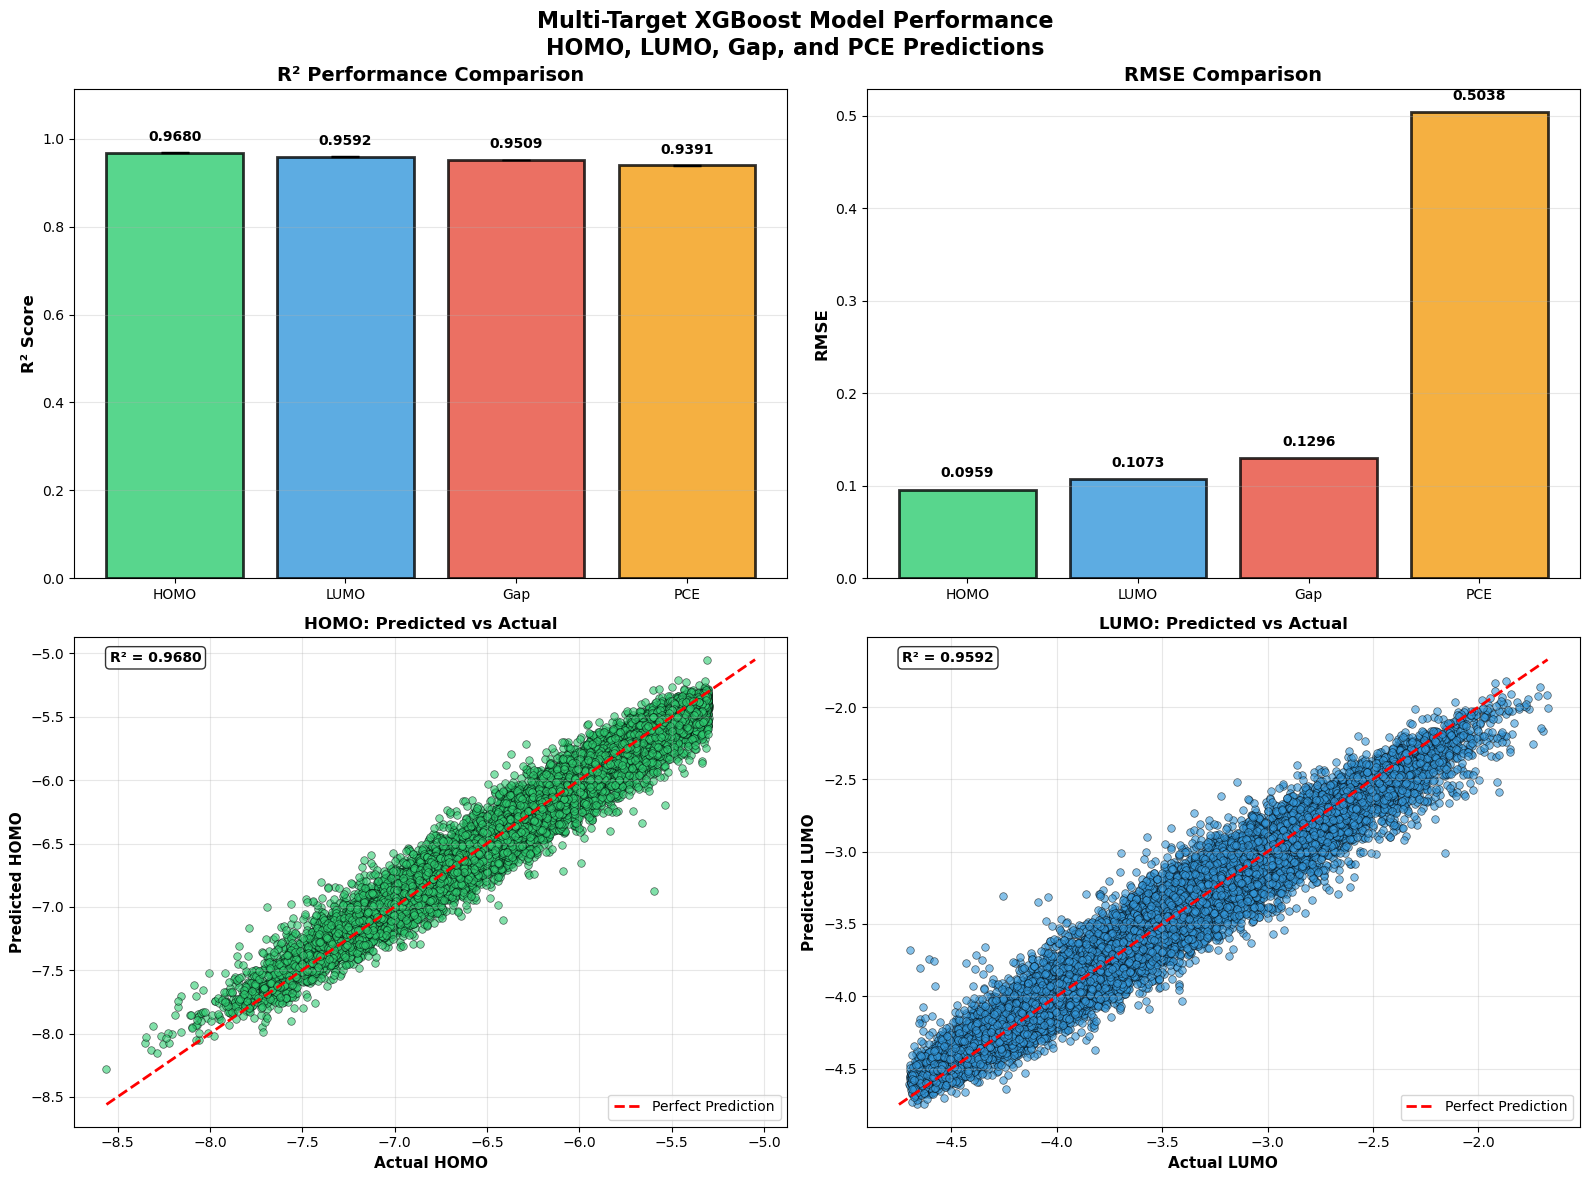

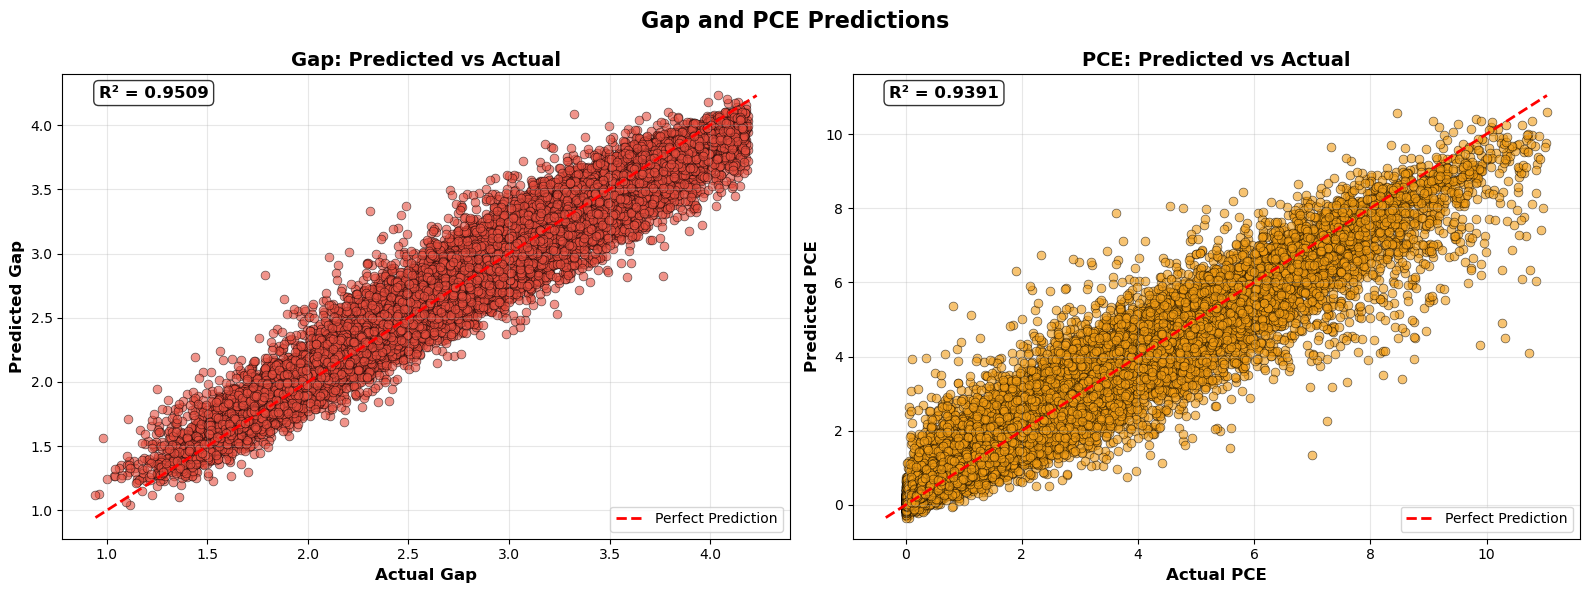

In [18]:
"""
MULTI-TARGET PREDICTIONS: HOMO, LUMO, Gap, and PCE
===================================================
Features: 35 RDKit descriptors + 2048 Morgan fingerprints
Model: XGBoost with Optuna-optimized hyperparameters
Dataset: Organic molecules
"""

import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors, rdFingerprintGenerator
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("MULTI-TARGET MODEL: HOMO, LUMO, Gap, PCE PREDICTIONS")
print("="*70)

# ============================================================================
# FEATURE EXTRACTION
# ============================================================================

def get_rdkit_descriptors(smiles):
    """Extract 35 RDKit molecular descriptors"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    try:
        features = {
            'num_aromatic_rings': Descriptors.NumAromaticRings(mol),
            'num_aromatic_bonds': sum([1 for b in mol.GetBonds() if b.GetIsAromatic()]),
            'num_aromatic_carbocycles': Descriptors.NumAromaticCarbocycles(mol),
            'num_aromatic_heterocycles': Descriptors.NumAromaticHeterocycles(mol),
            'num_heteroatoms': Descriptors.NumHeteroatoms(mol),
            'num_saturated_rings': Descriptors.NumSaturatedRings(mol),
            'fraction_sp2': sum([1 for a in mol.GetAtoms() 
                                if a.GetHybridization() == Chem.HybridizationType.SP2]) / max(mol.GetNumAtoms(), 1),
            'fraction_sp3': sum([1 for a in mol.GetAtoms() 
                                if a.GetHybridization() == Chem.HybridizationType.SP3]) / max(mol.GetNumAtoms(), 1),
            'fraction_aromatic': sum([1 for a in mol.GetAtoms() 
                                     if a.GetIsAromatic()]) / max(mol.GetNumAtoms(), 1),
            'molecular_weight': Descriptors.MolWt(mol),
            'num_atoms': mol.GetNumAtoms(),
            'num_heavy_atoms': mol.GetNumHeavyAtoms(),
            'num_rings': rdMolDescriptors.CalcNumRings(mol),
            'num_rotatable_bonds': Lipinski.NumRotatableBonds(mol),
            'num_hbd': Lipinski.NumHDonors(mol),
            'num_hba': Lipinski.NumHAcceptors(mol),
            'tpsa': Descriptors.TPSA(mol),
            'bertz_complexity': Descriptors.BertzCT(mol),
            'kappa1': Descriptors.Kappa1(mol),
            'kappa2': Descriptors.Kappa2(mol),
            'kappa3': Descriptors.Kappa3(mol),
            'max_estate': Descriptors.MaxEStateIndex(mol),
            'min_estate': Descriptors.MinEStateIndex(mol),
            'mol_logp': Descriptors.MolLogP(mol),
            'mol_mr': Descriptors.MolMR(mol),
            'chi0v': Descriptors.Chi0v(mol),
            'chi1v': Descriptors.Chi1v(mol),
            'chi2v': Descriptors.Chi2v(mol),
            'chi3v': Descriptors.Chi3v(mol),
            'chi4v': Descriptors.Chi4v(mol),
            'total_valence': sum([a.GetTotalValence() for a in mol.GetAtoms()]),
            'formal_charge': Chem.GetFormalCharge(mol),
            'num_carbon': sum([1 for a in mol.GetAtoms() if a.GetSymbol() == 'C']),
            'num_nitrogen': sum([1 for a in mol.GetAtoms() if a.GetSymbol() == 'N']),
            'num_oxygen': sum([1 for a in mol.GetAtoms() if a.GetSymbol() == 'O']),
            'num_sulfur': sum([1 for a in mol.GetAtoms() if a.GetSymbol() == 'S']),
        }
        
        return list(features.values())
    except Exception as e:
        print(f"Error extracting RDKit features: {e}")
        return None


def get_morgan_fingerprint(smiles, radius=2, n_bits=2048):
    """Generate 2048-bit Morgan fingerprints (radius=2)"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    try:
        generator = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=n_bits)
        fp = generator.GetFingerprint(mol)
        
        arr = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        
        return arr.tolist()
    except Exception as e:
        print(f"Error generating Morgan fingerprint: {e}")
        return None


def get_combined_features(smiles):
    """Combine RDKit + Morgan features (2083 total)"""
    rdkit_features = get_rdkit_descriptors(smiles)
    if rdkit_features is None:
        return None
    
    morgan_fp = get_morgan_fingerprint(smiles, radius=2, n_bits=2048)
    if morgan_fp is None:
        return None
    
    return rdkit_features + morgan_fp


# ============================================================================
# OPTIMIZED MODEL PARAMETERS (from Optuna optimization)
# ============================================================================

# XGBoost parameters optimized for Gap prediction
# These work well as a starting point for other targets too
BEST_PARAMS = {
    'n_estimators': 1083,
    'max_depth': 9,
    'learning_rate': 0.072,
    'subsample': 0.971,
    'colsample_bytree': 0.539,
    'gamma': 0.005,
    'reg_alpha': 1.085,
    'reg_lambda': 2.985,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 0
}


# ============================================================================
# CROSS-VALIDATION
# ============================================================================

def evaluate_model(X, y, target_name='Target'):
    """5-fold cross-validation with optimized XGBoost"""
    
    print(f"\n{'='*70}")
    print(f"EVALUATING: {target_name}")
    print(f"{'='*70}")
    print(f"Features: {X.shape[1]} (35 RDKit + 2048 Morgan)")
    print(f"Samples: {X.shape[0]}")
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_r2 = []
    fold_rmse = []
    fold_mae = []
    all_predictions = []
    all_actuals = []
    
    for fold_num, (train_idx, val_idx) in enumerate(kfold.split(X)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Train optimized XGBoost model
        model = XGBRegressor(**BEST_PARAMS)
        model.fit(X_train_scaled, y_train)
        
        # Predict
        y_pred = model.predict(X_val_scaled)
        
        # Metrics
        r2 = r2_score(y_val, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        
        fold_r2.append(r2)
        fold_rmse.append(rmse)
        fold_mae.append(mae)
        
        all_predictions.extend(y_pred)
        all_actuals.extend(y_val)
        
        print(f"  Fold {fold_num+1}: R²={r2:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}")
    
    # Summary
    print(f"\nSummary:")
    print(f"  R²:   {np.mean(fold_r2):.4f} ± {np.std(fold_r2):.4f}")
    print(f"  RMSE: {np.mean(fold_rmse):.4f} ± {np.std(fold_rmse):.4f}")
    print(f"  MAE:  {np.mean(fold_mae):.4f} ± {np.std(fold_mae):.4f}")
    print(f"  R² by fold: {[f'{r:.4f}' for r in fold_r2]}")
    
    return {
        'target': target_name,
        'r2_mean': np.mean(fold_r2),
        'r2_std': np.std(fold_r2),
        'rmse_mean': np.mean(fold_rmse),
        'rmse_std': np.std(fold_rmse),
        'mae_mean': np.mean(fold_mae),
        'mae_std': np.std(fold_mae),
        'r2_folds': fold_r2,
        'all_predictions': all_predictions,
        'all_actuals': all_actuals
    }


# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_multi_target_results(results_dict):
    """Create comprehensive visualization for all targets"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    targets = list(results_dict.keys())
    
    # Plot 1: R² comparison
    ax1 = axes[0, 0]
    r2_means = [results_dict[t]['r2_mean'] for t in targets]
    r2_stds = [results_dict[t]['r2_std'] for t in targets]
    
    colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
    bars = ax1.bar(targets, r2_means, yerr=r2_stds, capsize=10,
                   color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    
    for bar, value in zip(bars, r2_means):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
    
    ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
    ax1.set_title('R² Performance Comparison', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(0, max(r2_means) * 1.15)
    
    # Plot 2: RMSE comparison
    ax2 = axes[0, 1]
    rmse_means = [results_dict[t]['rmse_mean'] for t in targets]
    
    bars = ax2.bar(targets, rmse_means, color=colors, alpha=0.8,
                   edgecolor='black', linewidth=2)
    
    for bar, value in zip(bars, rmse_means):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(rmse_means)*0.02,
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
    
    ax2.set_ylabel('RMSE', fontsize=12, fontweight='bold')
    ax2.set_title('RMSE Comparison', fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    # Plot 3 & 4: Predicted vs Actual for each target
    for idx, (target, ax) in enumerate(zip(targets, [axes[1, 0], axes[1, 1], axes[0, 0], axes[0, 1]])):
        if idx >= 2:  # Create new subplots for targets 3 and 4
            continue
            
        result = results_dict[target]
        
        if idx < 2:
            ax = axes[1, idx]
            ax.scatter(result['all_actuals'], result['all_predictions'],
                      alpha=0.6, s=30, color=colors[idx], edgecolor='black', linewidth=0.5)
            
            min_val = min(min(result['all_actuals']), min(result['all_predictions']))
            max_val = max(max(result['all_actuals']), max(result['all_predictions']))
            
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
            
            ax.set_xlabel(f'Actual {target}', fontsize=11, fontweight='bold')
            ax.set_ylabel(f'Predicted {target}', fontsize=11, fontweight='bold')
            ax.set_title(f'{target}: Predicted vs Actual', fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.legend()
            
            r2_overall = r2_score(result['all_actuals'], result['all_predictions'])
            ax.text(0.05, 0.95, f'R² = {r2_overall:.4f}', transform=ax.transAxes,
                   fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.suptitle('Multi-Target XGBoost Model Performance\nHOMO, LUMO, Gap, and PCE Predictions',
                 fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('multi_target_results.png', dpi=300, bbox_inches='tight')
    print("\n✓ Visualization saved to 'multi_target_results.png'")


def plot_additional_targets(results_dict):
    """Create additional plots for targets 3 and 4 (Gap and PCE)"""
    
    if len(results_dict) <= 2:
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    targets = list(results_dict.keys())
    colors = ['#e74c3c', '#f39c12']
    
    for idx, (target, ax) in enumerate(zip(targets[2:], axes)):
        result = results_dict[target]
        
        ax.scatter(result['all_actuals'], result['all_predictions'],
                  alpha=0.6, s=40, color=colors[idx], edgecolor='black', linewidth=0.5)
        
        min_val = min(min(result['all_actuals']), min(result['all_predictions']))
        max_val = max(max(result['all_actuals']), max(result['all_predictions']))
        
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
        
        ax.set_xlabel(f'Actual {target}', fontsize=12, fontweight='bold')
        ax.set_ylabel(f'Predicted {target}', fontsize=12, fontweight='bold')
        ax.set_title(f'{target}: Predicted vs Actual', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        r2_overall = r2_score(result['all_actuals'], result['all_predictions'])
        ax.text(0.05, 0.95, f'R² = {r2_overall:.4f}', transform=ax.transAxes,
               fontsize=12, fontweight='bold',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.suptitle('Gap and PCE Predictions', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('gap_pce_predictions.png', dpi=300, bbox_inches='tight')
    print("✓ Additional visualization saved to 'gap_pce_predictions.png'")


# ============================================================================
# MAIN
# ============================================================================

def main():
    # Load data
    print("\nLoading dataset...")
    df = pd.read_csv("mmc2_cleaned_2_no_zero_pce.csv")
    print(f"Dataset: {df.shape[0]} molecules")
    print(f"Columns: {list(df.columns)}")
    
    # Check for required columns
    required_columns = ['smiles', 'homo', 'lumo', 'gap', 'pce']
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        print(f"\n⚠ WARNING: Missing columns: {missing_columns}")
        print(f"Available columns: {list(df.columns)}")
        print("\nAttempting to find similar column names...")
        
        # Try to find similar column names (case-insensitive)
        column_mapping = {}
        for req_col in missing_columns:
            for df_col in df.columns:
                if req_col.lower() in df_col.lower():
                    column_mapping[req_col] = df_col
                    print(f"  Found '{df_col}' for '{req_col}'")
        
        if column_mapping:
            print(f"\nUsing mapped columns: {column_mapping}")
            # Rename columns
            df = df.rename(columns={v: k for k, v in column_mapping.items()})
        else:
            print("\n Could not find required columns. Please check your CSV file.")
            return None
    
    # Extract features
    print("\nExtracting features...")
    features = []
    valid_indices = []
    
    for idx, smiles in enumerate(df['smiles']):


        
        feat = get_combined_features(smiles)
        if feat is not None:
            features.append(feat)
            valid_indices.append(idx)
    
    X = np.array(features)
    df_valid = df.iloc[valid_indices].reset_index(drop=True)
    
    print(f"\n✓ Feature extraction complete!")
    print(f"  Valid molecules: {len(valid_indices)}")
    print(f"  Total features: {X.shape[1]}")
    print(f"  Removed {len(df) - len(valid_indices)} molecules with invalid SMILES")
    
    # Define targets
    targets = {
        'HOMO': 'homo',
        'LUMO': 'lumo',
        'Gap': 'gap',
        'PCE': 'pce'
    }
    
    # Check which targets are available
    available_targets = {}
    for target_name, column_name in targets.items():
        if column_name in df_valid.columns:
            # Check for valid data (not NaN, not infinite)
            valid_data = df_valid[column_name].dropna()
            valid_data = valid_data[np.isfinite(valid_data)]
            
            if len(valid_data) > 0:
                available_targets[target_name] = column_name
                print(f"✓ {target_name}: {len(valid_data)} valid samples")
            else:
                print(f"⚠ {target_name}: No valid data found")
        else:
            print(f"✗ {target_name}: Column '{column_name}' not found")
    
    if not available_targets:
        print("\n No valid targets found. Exiting.")
        return None
    
    # Evaluate all targets
    results_dict = {}
    
    for target_name, column_name in available_targets.items():
        y = df_valid[column_name].values
        
        # Remove samples with NaN or infinite values
        valid_mask = np.isfinite(y)
        X_clean = X[valid_mask]
        y_clean = y[valid_mask]
        
        if len(y_clean) < 50:  # Need at least 50 samples for 5-fold CV
            print(f"\n⚠ Skipping {target_name}: Only {len(y_clean)} valid samples (need at least 50)")
            continue
        
        # Evaluate model
        result = evaluate_model(X_clean, y_clean, target_name=target_name)
        results_dict[target_name] = result
    
    if not results_dict:
        print("\n❌ No targets could be evaluated. Exiting.")
        return None
    
    # Create visualizations
    print("\nCreating visualizations...")
    plot_multi_target_results(results_dict)
    if len(results_dict) > 2:
        plot_additional_targets(results_dict)
    
    # Save results
    print("\nSaving results...")
    summary_data = []
    for target_name, result in results_dict.items():
        summary_data.append({
            'Target': target_name,
            'R2_mean': result['r2_mean'],
            'R2_std': result['r2_std'],
            'RMSE_mean': result['rmse_mean'],
            'RMSE_std': result['rmse_std'],
            'MAE_mean': result['mae_mean'],
            'MAE_std': result['mae_std']
        })
    
    results_df = pd.DataFrame(summary_data)
    results_df.to_csv('multi_target_results.csv', index=False)
    print("✓ Results saved to 'multi_target_results.csv'")
    
    # Print final summary
    print(f"\n{'='*70}")
    print("FINAL SUMMARY - MULTI-TARGET PREDICTIONS")
    print(f"{'='*70}")
    print(f"\n{'Target':<10} {'R² Mean':<12} {'R² Std':<12} {'RMSE':<12} {'MAE':<12}")
    print("-" * 70)
    
    for target_name, result in results_dict.items():
        print(f"{target_name:<10} {result['r2_mean']:<12.4f} {result['r2_std']:<12.4f} "
              f"{result['rmse_mean']:<12.4f} {result['mae_mean']:<12.4f}")
    
    print(f"\n{'='*70}")
    print("MODEL DETAILS")
    print(f"{'='*70}")
    print(f"Features:     35 RDKit + 2048 Morgan = 2083 total")
    print(f"Algorithm:    XGBoost (Optuna-optimized)")
    print(f"CV Strategy:  5-fold cross-validation")
    print(f"Targets:      {', '.join(results_dict.keys())}")
    print(f"{'='*70}")
    
    return results_dict


if __name__ == "__main__":
    results = main()

Deep Learning Approaches

Small Dataset (316): 
Features:
GNN

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch_geometric.utils import add_self_loops
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# FEATURE EXTRACTOR (2D ONLY)
# ============================================================================

class FeatureExtractor2D:
    """
    Extracts 2D molecular features only (no 3D geometry):
    - 19 Atomic-level features (per atom)
    - 21 Molecular-level features (repeated for each atom)
    Total: 40 features per atom
    """
    
    def __init__(self):
        # Electronegativity values (Pauling scale)
        self.ELECTRONEGATIVITY = {
            1: 2.20, 6: 2.55, 7: 3.04, 8: 3.44, 9: 3.98,
            15: 2.19, 16: 2.58, 17: 3.16, 35: 2.96, 53: 2.66,
            5: 2.04, 14: 1.90, 34: 2.55, 0: 0.0
        }
        
        # Van der Waals radii (Angstroms)
        self.VDW_RADIUS = {
            1: 1.20, 6: 1.70, 7: 1.55, 8: 1.52, 9: 1.47,
            15: 1.80, 16: 1.80, 17: 1.75, 35: 1.85, 53: 1.98,
            5: 1.92, 14: 2.10, 34: 1.90, 0: 0.0
        }
        
        # Covalent radii (Angstroms)
        self.COVALENT_RADIUS = {
            1: 0.31, 6: 0.76, 7: 0.71, 8: 0.66, 9: 0.57,
            15: 1.07, 16: 1.05, 17: 1.02, 35: 1.20, 53: 1.39,
            5: 0.84, 14: 1.11, 34: 1.20, 0: 0.0
        }
        
        self.scaler = StandardScaler()
        self.scaler_fitted = False
    
    def get_atomic_features(self, atom):
        """Extract 19 atomic-level features per atom"""
        features = []
        
        # Basic properties (6)
        features.append(float(atom.GetDegree()))
        atomic_num = atom.GetAtomicNum()
        features.append(float(atomic_num))
        features.append(float(atom.GetTotalNumHs()))
        features.append(float(atom.GetTotalValence()))
        features.append(float(atom.GetNumRadicalElectrons()))
        features.append(float(atom.GetFormalCharge()))
        
        # Hybridization one-hot (5)
        hyb = atom.GetHybridization()
        hyb_types = [Chem.HybridizationType.SP, Chem.HybridizationType.SP2, 
                     Chem.HybridizationType.SP3, Chem.HybridizationType.SP3D, 
                     Chem.HybridizationType.SP3D2]
        for h in hyb_types:
            features.append(1.0 if hyb == h else 0.0)
        
        # Electronegativity (2)
        electroneg = self.ELECTRONEGATIVITY.get(atomic_num, 0.0)
        features.append(electroneg)
        features.append(1.0 if electroneg > 0.0 else 0.0)
        
        # Additional flags (3)
        features.append(1.0 if atom.GetNumImplicitHs() > 0 else 0.0)
        
        is_hydroxyl = 0.0
        if atom.GetSymbol() == 'O':
            for neighbor in atom.GetNeighbors():
                if neighbor.GetSymbol() == 'H':
                    is_hydroxyl = 1.0
                    break
        features.append(is_hydroxyl)
        
        features.append(1.0 if atom.GetIsAromatic() else 0.0)
        
        # Scaled features (3)
        atomic_mass = atom.GetMass()
        features.append((atomic_mass - 10.812) / 116.092)
        
        vdw_r = self.VDW_RADIUS.get(atomic_num, 1.5)
        features.append((vdw_r - 1.5) / 0.6)
        
        cov_r = self.COVALENT_RADIUS.get(atomic_num, 0.64)
        features.append((cov_r - 0.64) / 0.76)
        
        return features
    
    def get_molecular_features(self, mol):
        """Extract 21 molecular-level features"""
        features = {}
        
        # Ring/aromatic (2)
        features['has_ring'] = 1.0 if rdMolDescriptors.CalcNumRings(mol) > 0 else 0.0
        features['is_aromatic'] = 1.0 if any(atom.GetIsAromatic() for atom in mol.GetAtoms()) else 0.0
        
        # Charge/degree (2)
        features['formal_charge'] = float(Chem.GetFormalCharge(mol))
        degrees = [atom.GetDegree() for atom in mol.GetAtoms()]
        features['min_degree'] = float(min(degrees)) if degrees else 0.0
        
        # Hydrogen bonding (3)
        features['num_hbond_donors'] = float(Lipinski.NumHDonors(mol))
        features['hba'] = float(Lipinski.NumHAcceptors(mol))
        features['hbd'] = float(Lipinski.NumHDonors(mol))
        
        # Topology (2)
        features['num_rings'] = float(rdMolDescriptors.CalcNumRings(mol))
        features['num_rotatable_bonds'] = float(Lipinski.NumRotatableBonds(mol))
        
        # Surface/size (3)
        features['polar_surface_area'] = float(Descriptors.TPSA(mol))
        features['molecular_weight'] = float(Descriptors.MolWt(mol))
        features['num_atoms'] = float(mol.GetNumAtoms())
        
        # Hybridization (1)
        sp2_count = sum(1 for atom in mol.GetAtoms() 
                       if atom.GetHybridization() == Chem.HybridizationType.SP2)
        features['fraction_sp2'] = sp2_count / max(mol.GetNumAtoms(), 1)
        
        # Valence/electroneg (2)
        features['valence'] = float(sum(atom.GetTotalValence() for atom in mol.GetAtoms()))
        electroneg_values = [self.ELECTRONEGATIVITY.get(atom.GetAtomicNum(), 0.0) 
                            for atom in mol.GetAtoms()]
        features['general_electronegativity'] = np.mean([e for e in electroneg_values if e > 0]) if electroneg_values else 0.0
        
        # Additional descriptors (6)
        features['num_aromatic_rings'] = float(Descriptors.NumAromaticRings(mol))
        features['num_heteroatoms'] = float(Descriptors.NumHeteroatoms(mol))
        features['num_heavy_atoms'] = float(mol.GetNumHeavyAtoms())
        features['bertz_complexity'] = float(Descriptors.BertzCT(mol))
        features['mol_logp'] = float(Descriptors.MolLogP(mol))
        features['chi0v'] = float(Descriptors.Chi0v(mol))
        
        return features
    
    def fit_scaler(self, smiles_list):
        """Fit scaler on molecular features"""
        print("Fitting scaler on molecular features...")
        
        all_molecular = []
        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                continue
            mol_features = self.get_molecular_features(mol)
            all_molecular.append(list(mol_features.values()))
        
        self.scaler.fit(all_molecular)
        self.scaler_fitted = True
        print(f"Scaler fitted on {len(all_molecular)} molecules")
    
    def smiles_to_pyg_data(self, smiles, target=None):
        """Convert SMILES to PyG Data with 2D features only"""
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        
        mol = Chem.AddHs(mol)
        
        # Get molecular features (21)
        mol_features = self.get_molecular_features(mol)
        mol_feature_vector = list(mol_features.values())
        
        # Scale molecular features
        if self.scaler_fitted:
            mol_feature_vector = self.scaler.transform([mol_feature_vector])[0].tolist()
        
        # Build node features: atomic (19) + molecular (21) = 40 per atom
        node_features = []
        for atom in mol.GetAtoms():
            atomic_feat = self.get_atomic_features(atom)
            combined = atomic_feat + mol_feature_vector
            node_features.append(combined)
        
        x = torch.tensor(node_features, dtype=torch.float)
        
        # Build edge index
        edge_indices = []
        for bond in mol.GetBonds():
            i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            edge_indices.extend([[i, j], [j, i]])
        
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t() if edge_indices else torch.zeros(2, 0, dtype=torch.long)
        
        # Create PyG Data
        data = Data(x=x, edge_index=edge_index)
        data.smiles = smiles
        
        if target is not None:
            data.y = torch.tensor(target, dtype=torch.float)
        
        return data


# ============================================================================
# GNN MODEL
# ============================================================================

class TChemGNN(nn.Module):
    """Graph Attention Network for molecular property prediction"""
    
    def __init__(self, node_feature_dim, hidden_channels=28, num_gat_layers=5, 
                 output_dim=3, heads=1, dropout=0.0):
        super(TChemGNN, self).__init__()
        
        self.num_gat_layers = num_gat_layers
        self.dropout = dropout
        
        # GAT layers
        self.gat_layers = nn.ModuleList()
        self.gat_layers.append(GATConv(node_feature_dim, hidden_channels, heads=heads, dropout=dropout))
        
        for _ in range(num_gat_layers - 1):
            self.gat_layers.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout))
        
        # Output layer
        self.output_layer = nn.Linear(hidden_channels * heads, output_dim)
        
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Model parameters: {total_params:,}")
    
    def forward(self, data):
        """Forward pass - uses last node prediction"""
        x, edge_index = data.x, data.edge_index
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        
        # GAT layers with tanh activation
        h = x
        for gat in self.gat_layers:
            h = gat(h, edge_index)
            h = torch.tanh(h)
            if self.dropout > 0:
                h = F.dropout(h, p=self.dropout, training=self.training)
        
        # Get predictions per node
        node_preds = self.output_layer(h)
        
        # Use last node prediction
        prediction = node_preds[-1].unsqueeze(0)
        
        return prediction


# ============================================================================
# TRAINING & EVALUATION
# ============================================================================

def train_epoch(model, data_list, optimizer, criterion, device):
    """Train one epoch"""
    model.train()
    total_loss = 0
    
    for data in data_list:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.squeeze(), data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(data_list)


def evaluate(model, data_list, device):
    """Evaluate model"""
    model.eval()
    all_preds, all_targets = [], []
    total_loss = 0
    criterion = nn.MSELoss()
    
    with torch.no_grad():
        for data in data_list:
            data = data.to(device)
            output = model(data)
            loss = criterion(output.squeeze(), data.y)
            total_loss += loss.item()
            all_preds.append(output.cpu().numpy())
            all_targets.append(data.y.cpu().numpy())
    
    preds = np.vstack(all_preds)
    targets = np.vstack(all_targets)
    
    metrics = {}
    props = ['HOMO', 'LUMO', 'Gap']
    for i, prop in enumerate(props):
        rmse = np.sqrt(mean_squared_error(targets[:, i], preds[:, i]))
        r2 = r2_score(targets[:, i], preds[:, i])
        metrics[prop] = {'RMSE': rmse, 'R2': r2}
    
    return metrics, total_loss / len(data_list)


# ============================================================================
# CROSS-VALIDATION
# ============================================================================

def cross_validate(data_list, node_feat_dim, device, n_folds=5, epochs=150):
    """5-fold cross-validation"""
    
    print(f"\n{'='*70}")
    print(f"5-FOLD CROSS-VALIDATION (2D FEATURES ONLY)")
    print(f"{'='*70}")
    
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    all_fold_metrics = []
    
    for fold_num, (train_idx, test_idx) in enumerate(kfold.split(data_list)):
        print(f"\nFold {fold_num + 1}/{n_folds}")
        
        train_data = [data_list[i] for i in train_idx]
        test_data = [data_list[i] for i in test_idx]
        
        # Initialize model
        model = TChemGNN(
            node_feature_dim=node_feat_dim,
            hidden_channels=28,
            num_gat_layers=5,
            output_dim=3,
            heads=1,
            dropout=0.0
        ).to(device)
        
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()
        
        best_test_loss = float('inf')
        patience, patience_counter = 30, 0
        
        for epoch in range(epochs):
            train_loss = train_epoch(model, train_data, optimizer, criterion, device)
            test_metrics, test_loss = evaluate(model, test_data, device)
            
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                patience_counter = 0
                best_metrics = test_metrics
            else:
                patience_counter += 1
            
            if epoch % 30 == 0:
                print(f"  Epoch {epoch}: Train={train_loss:.4f}, Test={test_loss:.4f}")
            
            if patience_counter >= patience:
                print(f"  Early stopping at epoch {epoch}")
                break
        
        print(f"  Best - Gap R²: {best_metrics['Gap']['R2']:.4f}, HOMO R²: {best_metrics['HOMO']['R2']:.4f}, LUMO R²: {best_metrics['LUMO']['R2']:.4f}")
        all_fold_metrics.append(best_metrics)
    
    # Summary
    print(f"\n{'='*70}")
    print("FINAL RESULTS")
    print(f"{'='*70}")
    
    for prop in ['HOMO', 'LUMO', 'Gap']:
        r2_scores = [f[prop]['R2'] for f in all_fold_metrics]
        rmse_scores = [f[prop]['RMSE'] for f in all_fold_metrics]
        
        print(f"\n{prop}:")
        print(f"  RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
        print(f"  R²:   {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
        print(f"  R² by fold: {[f'{s:.3f}' for s in r2_scores]}")
    
    return all_fold_metrics


# ============================================================================
# MAIN
# ============================================================================

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}\n")
    
    # Load data
    print("Loading dataset...")
    df = pd.read_csv("41597_2016_BFsdata201686_MOESM94_ESM.csv")
    print(f"Dataset shape: {df.shape}")
    
    # Initialize feature extractor
    extractor = FeatureExtractor2D()
    
    # Fit scaler
    smiles_list = df['smiles'].tolist()
    extractor.fit_scaler(smiles_list)
    
    # Convert to PyG Data
    print("\nConverting molecules to graph data...")
    data_list = []
    for idx, row in df.iterrows():
        if idx % 50 == 0:
            print(f"  Processing {idx}/{len(df)}...")
        
        target = [row['homo'], row['lumo'], row['gap']]
        if any(pd.isna(v) for v in target):
            continue
        
        data = extractor.smiles_to_pyg_data(row['smiles'], target)
        if data is not None:
            data_list.append(data)
    
    print(f"\n✓ Valid molecules: {len(data_list)}")
    node_feat_dim = data_list[0].x.size(1)
    print(f"✓ Node features per atom: {node_feat_dim} (19 atomic + 21 molecular)")
    
    # Run cross-validation
    results = cross_validate(data_list, node_feat_dim, device, n_folds=5, epochs=150)
    
    # Save results
    summary = []
    for prop in ['HOMO', 'LUMO', 'Gap']:
        r2_scores = [f[prop]['R2'] for f in results]
        rmse_scores = [f[prop]['RMSE'] for f in results]
        summary.append({
            'Property': prop,
            'R2_mean': np.mean(r2_scores),
            'R2_std': np.std(r2_scores),
            'RMSE_mean': np.mean(rmse_scores),
            'RMSE_std': np.std(rmse_scores)
        })
    
    results_df = pd.DataFrame(summary)
    results_df.to_csv('gnn_2d_results.csv', index=False)
    print(f"\n✓ Results saved to 'gnn_2d_results.csv'")
    
    return results


if __name__ == "__main__":
    results = main()

Using device: cpu

Loading dataset...
Dataset shape: (316, 5)
Fitting scaler on molecular features...
Scaler fitted on 316 molecules

Converting molecules to graph data...
  Processing 0/316...
  Processing 50/316...
  Processing 100/316...
  Processing 150/316...
  Processing 200/316...
  Processing 250/316...
  Processing 300/316...

✓ Valid molecules: 316
✓ Node features per atom: 40 (19 atomic + 21 molecular)

5-FOLD CROSS-VALIDATION (2D FEATURES ONLY)

Fold 1/5
Model parameters: 4,763
  Epoch 0: Train=0.0023, Test=0.0005
  Epoch 30: Train=0.0003, Test=0.0003
  Early stopping at epoch 48
  Best - Gap R²: 0.4933, HOMO R²: 0.5463, LUMO R²: 0.1935

Fold 2/5
Model parameters: 4,763
  Epoch 0: Train=0.0023, Test=0.0004
  Epoch 30: Train=0.0002, Test=0.0002
  Epoch 60: Train=0.0001, Test=0.0002
  Early stopping at epoch 62
  Best - Gap R²: 0.6545, HOMO R²: 0.3588, LUMO R²: 0.2957

Fold 3/5
Model parameters: 4,763
  Epoch 0: Train=0.0024, Test=0.0008
  Epoch 30: Train=0.0003, Test=0.0002


Same set up but with Large Dataset 

In [22]:
pip install torch_geometric

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch_geometric.utils import add_self_loops
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# FEATURE EXTRACTOR (2D ONLY)
# ============================================================================

class FeatureExtractor2D:
    """
    Extracts 2D molecular features only (no 3D geometry):
    - 19 Atomic-level features (per atom)
    - 21 Molecular-level features (repeated for each atom)
    Total: 40 features per atom
    """
    
    def __init__(self):
        # Electronegativity values (Pauling scale)
        self.ELECTRONEGATIVITY = {
            1: 2.20, 6: 2.55, 7: 3.04, 8: 3.44, 9: 3.98,
            15: 2.19, 16: 2.58, 17: 3.16, 35: 2.96, 53: 2.66,
            5: 2.04, 14: 1.90, 34: 2.55, 0: 0.0
        }
        
        # Van der Waals radii (Angstroms)
        self.VDW_RADIUS = {
            1: 1.20, 6: 1.70, 7: 1.55, 8: 1.52, 9: 1.47,
            15: 1.80, 16: 1.80, 17: 1.75, 35: 1.85, 53: 1.98,
            5: 1.92, 14: 2.10, 34: 1.90, 0: 0.0
        }
        
        # Covalent radii (Angstroms)
        self.COVALENT_RADIUS = {
            1: 0.31, 6: 0.76, 7: 0.71, 8: 0.66, 9: 0.57,
            15: 1.07, 16: 1.05, 17: 1.02, 35: 1.20, 53: 1.39,
            5: 0.84, 14: 1.11, 34: 1.20, 0: 0.0
        }
        
        self.scaler = StandardScaler()
        self.scaler_fitted = False
    
    def get_atomic_features(self, atom):
        """Extract 19 atomic-level features per atom"""
        features = []
        
        # Basic properties (6)
        features.append(float(atom.GetDegree()))
        atomic_num = atom.GetAtomicNum()
        features.append(float(atomic_num))
        features.append(float(atom.GetTotalNumHs()))
        features.append(float(atom.GetTotalValence()))
        features.append(float(atom.GetNumRadicalElectrons()))
        features.append(float(atom.GetFormalCharge()))
        
        # Hybridization one-hot (5)
        hyb = atom.GetHybridization()
        hyb_types = [Chem.HybridizationType.SP, Chem.HybridizationType.SP2, 
                     Chem.HybridizationType.SP3, Chem.HybridizationType.SP3D, 
                     Chem.HybridizationType.SP3D2]
        for h in hyb_types:
            features.append(1.0 if hyb == h else 0.0)
        
        # Electronegativity (2)
        electroneg = self.ELECTRONEGATIVITY.get(atomic_num, 0.0)
        features.append(electroneg)
        features.append(1.0 if electroneg > 0.0 else 0.0)
        
        # Additional flags (3)
        features.append(1.0 if atom.GetNumImplicitHs() > 0 else 0.0)
        
        is_hydroxyl = 0.0
        if atom.GetSymbol() == 'O':
            for neighbor in atom.GetNeighbors():
                if neighbor.GetSymbol() == 'H':
                    is_hydroxyl = 1.0
                    break
        features.append(is_hydroxyl)
        
        features.append(1.0 if atom.GetIsAromatic() else 0.0)
        
        # Scaled features (3)
        atomic_mass = atom.GetMass()
        features.append((atomic_mass - 10.812) / 116.092)
        
        vdw_r = self.VDW_RADIUS.get(atomic_num, 1.5)
        features.append((vdw_r - 1.5) / 0.6)
        
        cov_r = self.COVALENT_RADIUS.get(atomic_num, 0.64)
        features.append((cov_r - 0.64) / 0.76)
        
        return features
    
    def get_molecular_features(self, mol):
        """Extract 21 molecular-level features"""
        features = {}
        
        # Ring/aromatic (2)
        features['has_ring'] = 1.0 if rdMolDescriptors.CalcNumRings(mol) > 0 else 0.0
        features['is_aromatic'] = 1.0 if any(atom.GetIsAromatic() for atom in mol.GetAtoms()) else 0.0
        
        # Charge/degree (2)
        features['formal_charge'] = float(Chem.GetFormalCharge(mol))
        degrees = [atom.GetDegree() for atom in mol.GetAtoms()]
        features['min_degree'] = float(min(degrees)) if degrees else 0.0
        
        # Hydrogen bonding (3)
        features['num_hbond_donors'] = float(Lipinski.NumHDonors(mol))
        features['hba'] = float(Lipinski.NumHAcceptors(mol))
        features['hbd'] = float(Lipinski.NumHDonors(mol))
        
        # Topology (2)
        features['num_rings'] = float(rdMolDescriptors.CalcNumRings(mol))
        features['num_rotatable_bonds'] = float(Lipinski.NumRotatableBonds(mol))
        
        # Surface/size (3)
        features['polar_surface_area'] = float(Descriptors.TPSA(mol))
        features['molecular_weight'] = float(Descriptors.MolWt(mol))
        features['num_atoms'] = float(mol.GetNumAtoms())
        
        # Hybridization (1)
        sp2_count = sum(1 for atom in mol.GetAtoms() 
                       if atom.GetHybridization() == Chem.HybridizationType.SP2)
        features['fraction_sp2'] = sp2_count / max(mol.GetNumAtoms(), 1)
        
        # Valence/electroneg (2)
        features['valence'] = float(sum(atom.GetTotalValence() for atom in mol.GetAtoms()))
        electroneg_values = [self.ELECTRONEGATIVITY.get(atom.GetAtomicNum(), 0.0) 
                            for atom in mol.GetAtoms()]
        features['general_electronegativity'] = np.mean([e for e in electroneg_values if e > 0]) if electroneg_values else 0.0
        
        # Additional descriptors (6)
        features['num_aromatic_rings'] = float(Descriptors.NumAromaticRings(mol))
        features['num_heteroatoms'] = float(Descriptors.NumHeteroatoms(mol))
        features['num_heavy_atoms'] = float(mol.GetNumHeavyAtoms())
        features['bertz_complexity'] = float(Descriptors.BertzCT(mol))
        features['mol_logp'] = float(Descriptors.MolLogP(mol))
        features['chi0v'] = float(Descriptors.Chi0v(mol))
        
        return features
    
    def fit_scaler(self, smiles_list):
        """Fit scaler on molecular features"""
        print("Fitting scaler on molecular features...")
        
        all_molecular = []
        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                continue
            mol_features = self.get_molecular_features(mol)
            all_molecular.append(list(mol_features.values()))
        
        self.scaler.fit(all_molecular)
        self.scaler_fitted = True
        print(f"Scaler fitted on {len(all_molecular)} molecules")
    
    def smiles_to_pyg_data(self, smiles, target=None):
        """Convert SMILES to PyG Data with 2D features only"""
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        
        mol = Chem.AddHs(mol)
        
        # Get molecular features (21)
        mol_features = self.get_molecular_features(mol)
        mol_feature_vector = list(mol_features.values())
        
        # Scale molecular features
        if self.scaler_fitted:
            mol_feature_vector = self.scaler.transform([mol_feature_vector])[0].tolist()
        
        # Build node features: atomic (19) + molecular (21) = 40 per atom
        node_features = []
        for atom in mol.GetAtoms():
            atomic_feat = self.get_atomic_features(atom)
            combined = atomic_feat + mol_feature_vector
            node_features.append(combined)
        
        x = torch.tensor(node_features, dtype=torch.float)
        
        # Build edge index
        edge_indices = []
        for bond in mol.GetBonds():
            i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            edge_indices.extend([[i, j], [j, i]])
        
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t() if edge_indices else torch.zeros(2, 0, dtype=torch.long)
        
        # Create PyG Data
        data = Data(x=x, edge_index=edge_index)
        data.smiles = smiles
        
        if target is not None:
            data.y = torch.tensor(target, dtype=torch.float)
        
        return data


# ============================================================================
# GNN MODEL
# ============================================================================

class TChemGNN(nn.Module):
    """Graph Attention Network for molecular property prediction"""
    
    def __init__(self, node_feature_dim, hidden_channels=28, num_gat_layers=5, 
                 output_dim=3, heads=1, dropout=0.0):
        super(TChemGNN, self).__init__()
        
        self.num_gat_layers = num_gat_layers
        self.dropout = dropout
        
        # GAT layers
        self.gat_layers = nn.ModuleList()
        self.gat_layers.append(GATConv(node_feature_dim, hidden_channels, heads=heads, dropout=dropout))
        
        for _ in range(num_gat_layers - 1):
            self.gat_layers.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout))
        
        # Output layer
        self.output_layer = nn.Linear(hidden_channels * heads, output_dim)
        
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Model parameters: {total_params:,}")
    
    def forward(self, data):
        """Forward pass - uses last node prediction"""
        x, edge_index = data.x, data.edge_index
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        
        # GAT layers with tanh activation
        h = x
        for gat in self.gat_layers:
            h = gat(h, edge_index)
            h = torch.tanh(h)
            if self.dropout > 0:
                h = F.dropout(h, p=self.dropout, training=self.training)
        
        # Get predictions per node
        node_preds = self.output_layer(h)
        
        # Use last node prediction
        prediction = node_preds[-1].unsqueeze(0)
        
        return prediction


# ============================================================================
# TRAINING & EVALUATION
# ============================================================================

def train_epoch(model, data_list, optimizer, criterion, device):
    """Train one epoch"""
    model.train()
    total_loss = 0
    
    for data in data_list:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.squeeze(), data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(data_list)


def evaluate(model, data_list, device):
    """Evaluate model"""
    model.eval()
    all_preds, all_targets = [], []
    total_loss = 0
    criterion = nn.MSELoss()
    
    with torch.no_grad():
        for data in data_list:
            data = data.to(device)
            output = model(data)
            loss = criterion(output.squeeze(), data.y)
            total_loss += loss.item()
            all_preds.append(output.cpu().numpy())
            all_targets.append(data.y.cpu().numpy())
    
    preds = np.vstack(all_preds)
    targets = np.vstack(all_targets)
    
    metrics = {}
    props = ['HOMO', 'LUMO', 'Gap']
    for i, prop in enumerate(props):
        rmse = np.sqrt(mean_squared_error(targets[:, i], preds[:, i]))
        r2 = r2_score(targets[:, i], preds[:, i])
        metrics[prop] = {'RMSE': rmse, 'R2': r2}
    
    return metrics, total_loss / len(data_list)


# ============================================================================
# CROSS-VALIDATION
# ============================================================================

def cross_validate(data_list, node_feat_dim, device, n_folds=5, epochs=150):
    """5-fold cross-validation"""
    
    print(f"\n{'='*70}")
    print(f"5-FOLD CROSS-VALIDATION (2D FEATURES ONLY)")
    print(f"{'='*70}")
    
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    all_fold_metrics = []
    
    for fold_num, (train_idx, test_idx) in enumerate(kfold.split(data_list)):
        print(f"\nFold {fold_num + 1}/{n_folds}")
        
        train_data = [data_list[i] for i in train_idx]
        test_data = [data_list[i] for i in test_idx]
        
        # Initialize model
        model = TChemGNN(
            node_feature_dim=node_feat_dim,
            hidden_channels=28,
            num_gat_layers=5,
            output_dim=3,
            heads=1,
            dropout=0.0
        ).to(device)
        
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()
        
        best_test_loss = float('inf')
        patience, patience_counter = 30, 0
        
        for epoch in range(epochs):
            train_loss = train_epoch(model, train_data, optimizer, criterion, device)
            test_metrics, test_loss = evaluate(model, test_data, device)
            
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                patience_counter = 0
                best_metrics = test_metrics
            else:
                patience_counter += 1
            
            if epoch % 30 == 0:
                print(f"  Epoch {epoch}: Train={train_loss:.4f}, Test={test_loss:.4f}")
            
            if patience_counter >= patience:
                print(f"  Early stopping at epoch {epoch}")
                break
        
        print(f"  Best - Gap R²: {best_metrics['Gap']['R2']:.4f}, HOMO R²: {best_metrics['HOMO']['R2']:.4f}, LUMO R²: {best_metrics['LUMO']['R2']:.4f}")
        all_fold_metrics.append(best_metrics)
    
    # Summary
    print(f"\n{'='*70}")
    print("FINAL RESULTS")
    print(f"{'='*70}")
    
    for prop in ['HOMO', 'LUMO', 'Gap']:
        r2_scores = [f[prop]['R2'] for f in all_fold_metrics]
        rmse_scores = [f[prop]['RMSE'] for f in all_fold_metrics]
        
        print(f"\n{prop}:")
        print(f"  RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
        print(f"  R²:   {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
        print(f"  R² by fold: {[f'{s:.3f}' for s in r2_scores]}")
    
    return all_fold_metrics


# ============================================================================
# MAIN
# ============================================================================

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}\n")
    
    # Load data
    print("Loading dataset...")
    df = pd.read_csv("mmc2_cleaned_2_no_zero_pce.csv")
    print(f"Dataset shape: {df.shape}")
    
    # Initialize feature extractor
    extractor = FeatureExtractor2D()
    
    # Fit scaler
    smiles_list = df['smiles'].tolist()
    extractor.fit_scaler(smiles_list)
    
    # Convert to PyG Data
    print("\nConverting molecules to graph data...")
    data_list = []
    for idx, row in df.iterrows():

        
        target = [row['homo'], row['lumo'], row['gap']]
        if any(pd.isna(v) for v in target):
            continue
        
        data = extractor.smiles_to_pyg_data(row['smiles'], target)
        if data is not None:
            data_list.append(data)
    
    print(f"\n✓ Valid molecules: {len(data_list)}")
    node_feat_dim = data_list[0].x.size(1)
    print(f"✓ Node features per atom: {node_feat_dim} (19 atomic + 21 molecular)")
    
    # Run cross-validation
    results = cross_validate(data_list, node_feat_dim, device, n_folds=5, epochs=150)
    
    # Save results
    summary = []
    for prop in ['HOMO', 'LUMO', 'Gap']:
        r2_scores = [f[prop]['R2'] for f in results]
        rmse_scores = [f[prop]['RMSE'] for f in results]
        summary.append({
            'Property': prop,
            'R2_mean': np.mean(r2_scores),
            'R2_std': np.std(r2_scores),
            'RMSE_mean': np.mean(rmse_scores),
            'RMSE_std': np.std(rmse_scores)
        })
    
    results_df = pd.DataFrame(summary)
    results_df.to_csv('Large_gnn_2d_results.csv', index=False)
    print(f"\n✓ Results saved to 'Large_gnn_2d_results.csv'")
    
    return results


if __name__ == "__main__":
    results = main()

Using device: cpu

Loading dataset...
Dataset shape: (48357, 5)
Fitting scaler on molecular features...
Scaler fitted on 48357 molecules

Converting molecules to graph data...

✓ Valid molecules: 48357
✓ Node features per atom: 40 (19 atomic + 21 molecular)

5-FOLD CROSS-VALIDATION (2D FEATURES ONLY)

Fold 1/5
Model parameters: 4,763
  Epoch 0: Train=0.1079, Test=0.1324


KeyboardInterrupt: 